In [ ]:
!sudo apt install tesseract-ocr
!pip install pytesseract

### functions 

In [ ]:
import cv2
import numpy as np


class Label:
    def __init__(self, cl=-1, tl=np.array([0., 0.]), br=np.array([0., 0.]), prob=None):
        self.__tl = tl
        self.__br = br
        self.__cl = cl
        self.__prob = prob

    def __str__(self):
        return 'Class: %d, top left(x: %f, y: %f), bottom right(x: %f, y: %f)' % (
        self.__cl, self.__tl[0], self.__tl[1], self.__br[0], self.__br[1])

    def copy(self):
        return Label(self.__cl, self.__tl, self.__br)

    def wh(self): return self.__br - self.__tl

    def cc(self): return self.__tl + self.wh() / 2

    def tl(self): return self.__tl

    def br(self): return self.__br

    def tr(self): return np.array([self.__br[0], self.__tl[1]])

    def bl(self): return np.array([self.__tl[0], self.__br[1]])

    def cl(self): return self.__cl

    def area(self): return np.prod(self.wh())

    def prob(self): return self.__prob

    def set_class(self, cl):
        self.__cl = cl

    def set_tl(self, tl):
        self.__tl = tl

    def set_br(self, br):
        self.__br = br

    def set_wh(self, wh):
        cc = self.cc()
        self.__tl = cc - .5 * wh
        self.__br = cc + .5 * wh

    def set_prob(self, prob):
        self.__prob = prob

class DLabel(Label):
    def __init__(self, cl, pts, prob):
        self.pts = pts
        tl = np.amin(pts, axis=1)
        br = np.amax(pts, axis=1)
        Label.__init__(self, cl, tl, br, prob)

def getWH(shape):
    return np.array(shape[1::-1]).astype(float)

def IOU(tl1, br1, tl2, br2):
    wh1, wh2 = br1-tl1, br2-tl2
    assert((wh1 >= 0).all() and (wh2 >= 0).all())
    
    intersection_wh = np.maximum(np.minimum(br1, br2) - np.maximum(tl1, tl2), 0)
    intersection_area = np.prod(intersection_wh)
    area1, area2 = (np.prod(wh1), np.prod(wh2))
    union_area = area1 + area2 - intersection_area
    return intersection_area/union_area

def IOU_labels(l1, l2):
    return IOU(l1.tl(), l1.br(), l2.tl(), l2.br())

def nms(Labels, iou_threshold=0.5):
    SelectedLabels = []
    Labels.sort(key=lambda l: l.prob(), reverse=True)
    
    for label in Labels:
        non_overlap = True
        for sel_label in SelectedLabels:
            if IOU_labels(label, sel_label) > iou_threshold:
                non_overlap = False
                break

        if non_overlap:
            SelectedLabels.append(label)
    return SelectedLabels



def find_T_matrix(pts, t_pts):
    A = np.zeros((8, 9))
    for i in range(0, 4):
        xi = pts[:, i]
        xil = t_pts[:, i]
        xi = xi.T
        
        A[i*2, 3:6] = -xil[2]*xi
        A[i*2, 6:] = xil[1]*xi
        A[i*2+1, :3] = xil[2]*xi
        A[i*2+1, 6:] = -xil[0]*xi

    [U, S, V] = np.linalg.svd(A)
    H = V[-1, :].reshape((3, 3))
    return H

def getRectPts(tlx, tly, brx, bry):
    return np.matrix([[tlx, brx, brx, tlx], [tly, tly, bry, bry], [1, 1, 1, 1]], dtype=float)

def normal(pts, side, mn, MN):
    pts_MN_center_mn = pts * side
    pts_MN = pts_MN_center_mn + mn.reshape((2, 1))
    pts_prop = pts_MN / MN.reshape((2, 1))
    return pts_prop

# Reconstruction function from predict value into plate crpoped from image
def reconstruct(I, Iresized, Yr, lp_threshold):
    # 4 max-pooling layers, stride = 2
    net_stride = 2**4
    side = ((208 + 40)/2)/net_stride

    # one line and two lines license plate size
    one_line = (470, 110)
    two_lines = (280, 200)

    Probs = Yr[..., 0]
    Affines = Yr[..., 2:]

    xx, yy = np.where(Probs > lp_threshold)
    # CNN input image size 
    WH = getWH(Iresized.shape)
    # output feature map size
    MN = WH/net_stride

    vxx = vyy = 0.5 #alpha
    base = lambda vx, vy: np.matrix([[-vx, -vy, 1], [vx, -vy, 1], [vx, vy, 1], [-vx, vy, 1]]).T
    labels = []
    labels_frontal = []

    for i in range(len(xx)):
        x, y = xx[i], yy[i]
        affine = Affines[x, y]
        prob = Probs[x, y]

        mn = np.array([float(y) + 0.5, float(x) + 0.5])

        # affine transformation matrix
        A = np.reshape(affine, (2, 3))
        A[0, 0] = max(A[0, 0], 0)
        A[1, 1] = max(A[1, 1], 0)
        # identity transformation
        B = np.zeros((2, 3))
        B[0, 0] = max(A[0, 0], 0)
        B[1, 1] = max(A[1, 1], 0)

        pts = np.array(A*base(vxx, vyy))
        pts_frontal = np.array(B*base(vxx, vyy))

        pts_prop = normal(pts, side, mn, MN)
        frontal = normal(pts_frontal, side, mn, MN)

        labels.append(DLabel(0, pts_prop, prob))
        labels_frontal.append(DLabel(0, frontal, prob))
        
    final_labels = nms(labels, 0.1)
    final_labels_frontal = nms(labels_frontal, 0.1)

    #print(final_labels_frontal)
    assert final_labels_frontal, "No License plate is founded!"

    # LP size and type
    out_size, lp_type = (two_lines, 2) if ((final_labels_frontal[0].wh()[0] / final_labels_frontal[0].wh()[1]) < 1.7) else (one_line, 1)

    TLp = []
    Cor = []
    if len(final_labels):
        final_labels.sort(key=lambda x: x.prob(), reverse=True)
        for _, label in enumerate(final_labels):
            t_ptsh = getRectPts(0, 0, out_size[0], out_size[1])
            ptsh = np.concatenate((label.pts * getWH(I.shape).reshape((2, 1)), np.ones((1, 4))))
            H = find_T_matrix(ptsh, t_ptsh)
            Ilp = cv2.warpPerspective(I, H, out_size, borderValue=0)
            TLp.append(Ilp)
            Cor.append(ptsh)
    return final_labels, TLp, lp_type, Cor

def detect_lp(model, I, max_dim, lp_threshold):
    min_dim_img = min(I.shape[:2])
    factor = float(max_dim) / min_dim_img
    w, h = (np.array(I.shape[1::-1], dtype=float) * factor).astype(int).tolist()
    Iresized = cv2.resize(I, (w, h))
    T = Iresized.copy()
    T = T.reshape((1, T.shape[0], T.shape[1], T.shape[2]))
    Yr = model.predict(T)
    Yr = np.squeeze(Yr)
    #print(Yr.shape)
    L, TLp, lp_type, Cor = reconstruct(I, Iresized, Yr, lp_threshold)
    return L, TLp, lp_type, Cor

### libraries


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from os.path import splitext,basename
from keras.models import model_from_json
import glob
import pytesseract
from PIL import Image

### functions for model loading

In [ ]:
def load_model(path):
    try:
        path = splitext(path)[0]
        with open('%s.json' % path, 'r') as json_file:
            model_json = json_file.read()
        model = model_from_json(model_json, custom_objects={})
        model.load_weights('%s.h5' % path)
        print("Loading model successfully...")
        return model
    except Exception as e:
        print(e)

In [ ]:
! git clone https://github.com/quangnhat185/Plate_detect_and_recognize.git

fatal: destination path 'Plate_detect_and_recognize' already exists and is not an empty directory.


In [ ]:
wpod_net_path = "/content/Plate_detect_and_recognize/wpod-net.json"
wpod_net = load_model(wpod_net_path)

Loading model successfully...


In [ ]:
def preprocess_image(image_path,resize=False):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img / 255
    if resize:
        img = cv2.resize(img, (224,224))
    return img

In [ ]:
def get_plate(image_path, Dmax=608, Dmin=256):
    vehicle = preprocess_image(image_path)
    ratio = float(max(vehicle.shape[:2])) / min(vehicle.shape[:2])
    print(vehicle.shape[:2])
    side = int(ratio * Dmin)
    print('side: ',side)
    bound_dim = min(side, Dmax)
    print('boundary: ',bound_dim)
    _ , LpImg, _, cor = detect_lp(wpod_net, vehicle, bound_dim, lp_threshold=0.5)
    return LpImg, cor

### test batches of images

1
(416, 416)
side:  256
boundary:  256
2
3
4
(416, 416)
side:  256
boundary:  256
5
6
7
(416, 416)
side:  256
boundary:  256
8
(416, 416)
side:  256
boundary:  256
9
(416, 416)
side:  256
boundary:  256
10
11
12
(416, 416)
side:  256
boundary:  256
13
14
15
(416, 416)
side:  256
boundary:  256
16
17
18
(416, 416)
side:  256
boundary:  256
19
(416, 416)
side:  256
boundary:  256
20
(416, 416)
side:  256
boundary:  256
21
(416, 416)
side:  256
boundary:  256
22
23
(416, 416)
side:  256
boundary:  256
24
25
(416, 416)
side:  256
boundary:  256
26
(416, 416)
side:  256
boundary:  256
27
28
29
30
(416, 416)
side:  256
boundary:  256


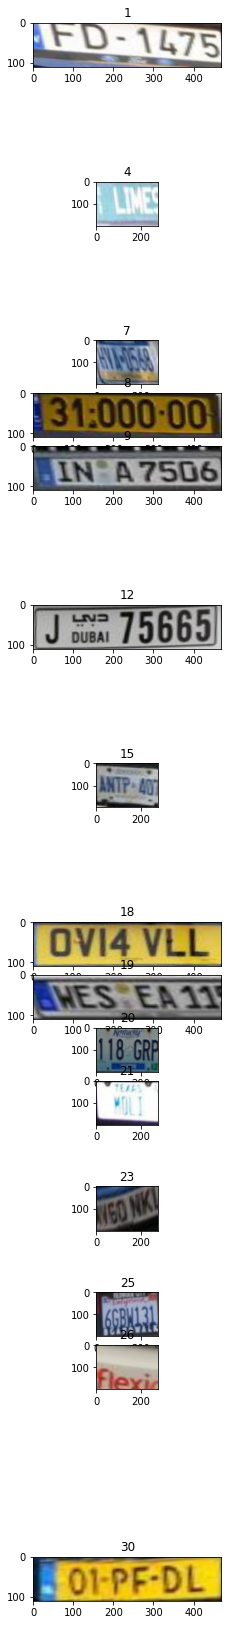

In [ ]:
# 14/30 
x=1
y=31
fig = plt.figure(figsize=(30,30))
fig_list = []

for i in range(x,y):
    img = '/content/{}.jpg'.format(i)
    #print(i,sep=' ',end='')
    print(i)
    if i in [2,3,5,6,10,11,13,14,16,17,22,24,27,28,29]:
      continue
    fig_list.append(fig.add_subplot(y,x,i))
    fig_list[-1].set_title(i)
    p,c=get_plate(img)
    plt.imshow(p[0])

31
32
33
(416, 416)
side:  256
boundary:  256
34
(416, 416)
side:  256
boundary:  256
35
36
(416, 416)
side:  256
boundary:  256
37
(416, 416)
side:  256
boundary:  256
38
39
(416, 416)
side:  256
boundary:  256
40
41
(416, 416)
side:  256
boundary:  256
42
43
(416, 416)
side:  256
boundary:  256
44
(416, 416)
side:  256
boundary:  256
45
(416, 416)
side:  256
boundary:  256
46
(416, 416)
side:  256
boundary:  256
47
48
(416, 416)
side:  256
boundary:  256
49
(416, 416)
side:  256
boundary:  256
50
51
52
(416, 416)
side:  256
boundary:  256
53
54
55
(416, 416)
side:  256
boundary:  256
56
57
(416, 416)
side:  256
boundary:  256
58
(416, 416)
side:  256
boundary:  256
59
(416, 416)
side:  256
boundary:  256
60
(416, 416)
side:  256
boundary:  256


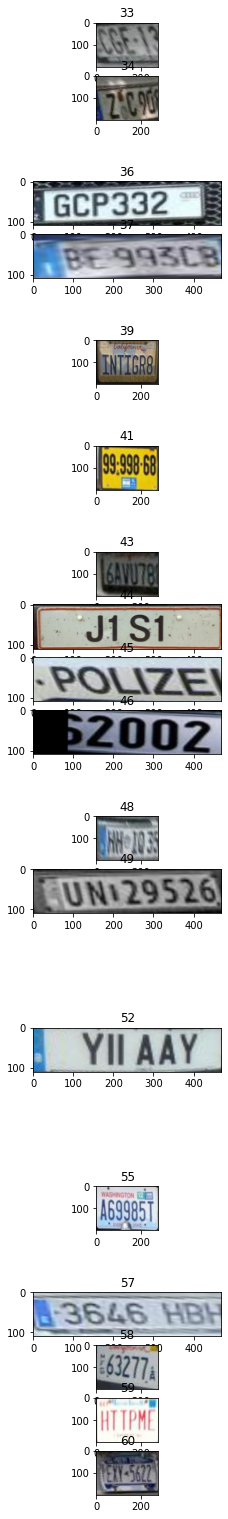

In [ ]:
# 18/30 
x=31
y=61
fig = plt.figure(figsize=(30,30))
fig_list = []

for i in range(x,y):
    img = '/content/{}.jpg'.format(i)
    #print(i,sep=' ',end='')
    print(i)
    if i in [31,32,35,38,40,42,47,50,51,53,54,56]:
      continue
    fig_list.append(fig.add_subplot(y-30,x-30,i-30))
    fig_list[-1].set_title(i)
    p,c=get_plate(img)
    plt.imshow(p[0])

61
62
(416, 416)
side:  256
boundary:  256
63
64
65
(416, 416)
side:  256
boundary:  256
66
67
(416, 416)
side:  256
boundary:  256
68
69
(416, 416)
side:  256
boundary:  256
70
(416, 416)
side:  256
boundary:  256


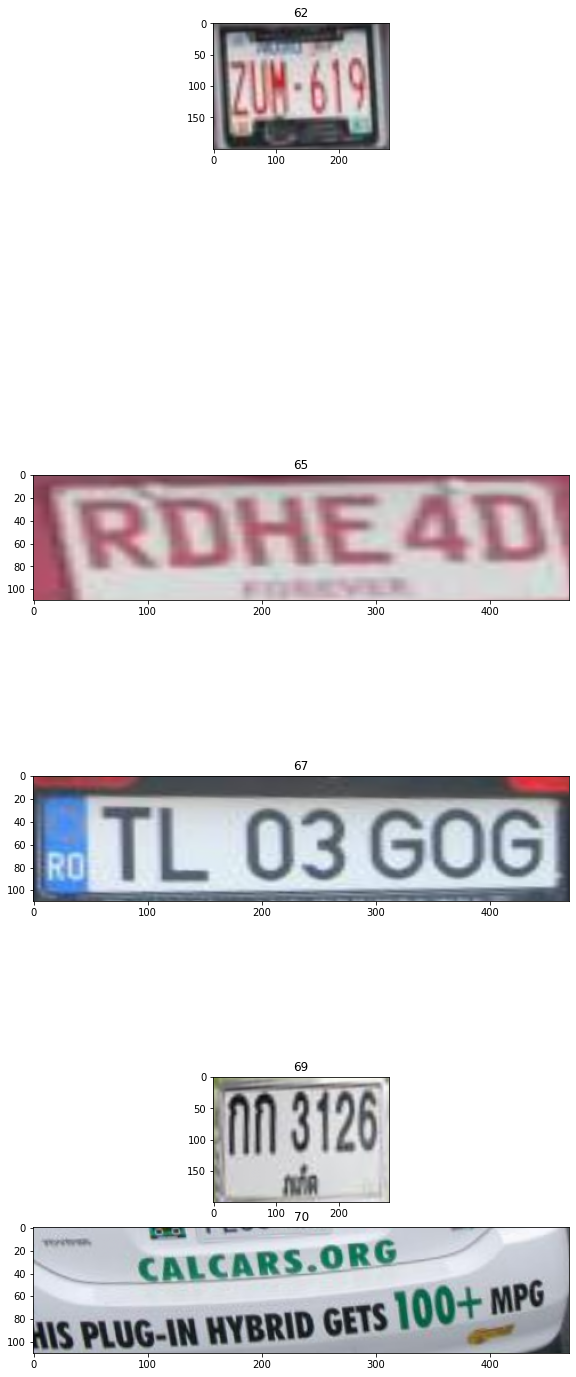

In [ ]:
# 4/30 
x=61
y=71
fig = plt.figure(figsize=(30,30))
fig_list = []

for i in range(x,y):
    img = '/content/{}.jpg'.format(i)
    #print(i,sep=' ',end='')
    print(i)
    if i in [61,63,64,66,68]:
      continue
    fig_list.append(fig.add_subplot(y-60,x-60,i-60))
    fig_list[-1].set_title(i)
    p,c=get_plate(img)
    plt.imshow(p[0])

### text predication

In [ ]:
l=[]
# batch 1
x=1
y=31

for i in range(x,y):
    img = '/content/{}.jpg'.format(i)
    #print(i,sep=' ',end='')
    print(i)
    if i in [2,3,5,6,10,11,13,14,16,17,22,24,27,28,29,61,63,64,66,68,31,32,35,38,40,42,47,50,51,53,54,56]:
      continue
    LpImg,cor = get_plate(img)
    im = Image.fromarray((LpImg[0]* 255).astype(np.uint8))
    text = pytesseract.image_to_string(im)
    l.append(['{}'.format(i),text])

1
(416, 416)
side:  256
boundary:  256
2
3
4
(416, 416)
side:  256
boundary:  256
5
6
7
(416, 416)
side:  256
boundary:  256
8
(416, 416)
side:  256
boundary:  256
9
(416, 416)
side:  256
boundary:  256
10
11
12
(416, 416)
side:  256
boundary:  256
13
14
15
(416, 416)
side:  256
boundary:  256
16
17
18
(416, 416)
side:  256
boundary:  256
19
(416, 416)
side:  256
boundary:  256
20
(416, 416)
side:  256
boundary:  256
21
(416, 416)
side:  256
boundary:  256
22
23
(416, 416)
side:  256
boundary:  256
24
25
(416, 416)
side:  256
boundary:  256
26
(416, 416)
side:  256
boundary:  256
27
28
29
30
(416, 416)
side:  256
boundary:  256


In [ ]:
l

[['1', '~\\4Q75\n\x0c'],
 ['4', '\x0c'],
 ['7', '\x0c'],
 ['8', ' \n\x0c'],
 ['9', '\x0c'],
 ['12', 'J tien 259665\n\x0c'],
 ['15', '\x0c'],
 ['18', 'VLL\n\x0c'],
 ['19', 'EWES EIT\n\x0c'],
 ['20', '\x0c'],
 ['21', '\x0c'],
 ['23', '\x0c'],
 ['25', '\x0c'],
 ['26', '\x0c'],
 ['30', '\x0c']]

In [ ]:
l=[]
# batch 2
x=31
y=61

for i in range(x,y):
    img = '/content/{}.jpg'.format(i)
    #print(i,sep=' ',end='')
    print(i)
    if i in [2,3,5,6,10,11,13,14,16,17,22,24,27,28,29,61,63,64,66,68,31,32,35,38,40,42,47,50,51,53,54,56]:
      continue
    LpImg,cor = get_plate(img)
    im = Image.fromarray((LpImg[0]* 255).astype(np.uint8))
    text = pytesseract.image_to_string(im)
    l.append(['{}'.format(i),text])

31
32
33
(416, 416)
side:  256
boundary:  256
34
(416, 416)
side:  256
boundary:  256
35
36
(416, 416)
side:  256
boundary:  256
37
(416, 416)
side:  256
boundary:  256
38
39
(416, 416)
side:  256
boundary:  256
40
41
(416, 416)
side:  256
boundary:  256
42
43
(416, 416)
side:  256
boundary:  256
44
(416, 416)
side:  256
boundary:  256
45
(416, 416)
side:  256
boundary:  256
46
(416, 416)
side:  256
boundary:  256
47
48
(416, 416)
side:  256
boundary:  256
49
(416, 416)
side:  256
boundary:  256
50
51
52
(416, 416)
side:  256
boundary:  256
53
54
55
(416, 416)
side:  256
boundary:  256
56
57
(416, 416)
side:  256
boundary:  256
58
(416, 416)
side:  256
boundary:  256
59
(416, 416)
side:  256
boundary:  256
60
(416, 416)
side:  256
boundary:  256


In [ ]:
l

[['33', 'i\n\x0c'],
 ['34', '\x0c'],
 ['36', '\x0c'],
 ['37', '= =e S508\n\x0c'],
 ['39', ' \n\x0c'],
 ['41', '\x0c'],
 ['43', '\x0c'],
 ['44', '\x0c'],
 ['45', '-POLIZE)\n\x0c'],
 ['46', '\x0c'],
 ['48', ' \n\x0c'],
 ['49', '\x0c'],
 ['52', '- YILAAY\n\x0c'],
 ['55', '\x0c'],
 ['57', 'A3545 HBR\n\x0c'],
 ['58', '\x0c'],
 ['59', '\x0c'],
 ['60', '\x0c']]

In [ ]:
l=[]
# batch 3
x=61
y=71

for i in range(x,y):
    img = '/content/{}.jpg'.format(i)
    #print(i,sep=' ',end='')
    print(i)
    if i in [2,3,5,6,10,11,13,14,16,17,22,24,27,28,29,61,63,64,66,68,31,32,35,38,40,42,47,50,51,53,54,56]:
      continue
    LpImg,cor = get_plate(img)
    im = Image.fromarray((LpImg[0]* 255).astype(np.uint8))
    text = pytesseract.image_to_string(im)
    l.append(['{}'.format(i),text])

61
62
(416, 416)
side:  256
boundary:  256
63
64
65
(416, 416)
side:  256
boundary:  256
66
67
(416, 416)
side:  256
boundary:  256
68
69
(416, 416)
side:  256
boundary:  256
70
(416, 416)
side:  256
boundary:  256


In [ ]:
l

[['62', '\x0c'],
 ['65', 'R\n\nARDHE 4D!\n\x0c'],
 ['67', '\x0c'],
 ['69', '\x0c'],
 ['70', 'nee E_ 7\n\nCALCARS.ORG “\nA\\S PLUG-IN HYBRID GETS yoo+™ Bs\n\x0c']]

### Results


*   38 out 0f 70 images were detected correctly
*   accuracy = 54.28%
* out of those 38 images, only 15 of them were correctly text recognised
* therefore the overall accuracy would be 21.42%



In [ ]:
!git clone https://github.com/clovaai/deep-text-recognition-benchmark
%cd deep-text-recognition-benchmark

Cloning into 'deep-text-recognition-benchmark'...
remote: Enumerating objects: 495, done.
remote: Total 495 (delta 0), reused 0 (delta 0), pack-reused 495
Receiving objects: 100% (495/495), 3.07 MiB | 12.77 MiB/s, done.
Resolving deltas: 100% (302/302), done.
/content/deep-text-recognition-benchmark


In [ ]:
models = {
    'None-ResNet-None-CTC.pth': 'https://drive.google.com/open?id=1FocnxQzFBIjDT2F9BkNUiLdo1cC3eaO0',
    'None-VGG-BiLSTM-CTC.pth': 'https://drive.google.com/open?id=1GGC2IRYEMQviZhqQpbtpeTgHO_IXWetG',
    'None-VGG-None-CTC.pth': 'https://drive.google.com/open?id=1FS3aZevvLiGF1PFBm5SkwvVcgI6hJWL9',
    'TPS-ResNet-BiLSTM-Attn-case-sensitive.pth': 'https://drive.google.com/open?id=1ajONZOgiG9pEYsQ-eBmgkVbMDuHgPCaY',
    'TPS-ResNet-BiLSTM-Attn.pth': 'https://drive.google.com/open?id=1b59rXuGGmKne1AuHnkgDzoYgKeETNMv9',
    'TPS-ResNet-BiLSTM-CTC.pth': 'https://drive.google.com/open?id=1FocnxQzFBIjDT2F9BkNUiLdo1cC3eaO0',
}

for k, v in models.items():
  doc_id = v[v.find('=')+1:]
  !curl -c /tmp/cookies "https://drive.google.com/uc?export=download&id=$doc_id" > /tmp/intermezzo.html
  !curl -L -b /tmp/cookies "https://drive.google.com$(cat /tmp/intermezzo.html | grep -Po 'uc-download-link" [^>]* href="\K[^"]*' | sed 's/\&amp;/\&/g')" > $k

!ls -al *.pth

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2230    0  2230    0     0  18130      0 --:--:-- --:--:-- --:--:-- 18130
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 93749    0 93749    0     0   863k      0 --:--:-- --:--:-- --:--:--  863k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:

In [ ]:
output= !python3 demo.py --Transformation TPS --FeatureExtraction ResNet --SequenceModeling BiLSTM --Prediction Attn --image_folder demo_image/ --saved_model TPS-ResNet-BiLSTM-Attn.pth

In [ ]:
output

['phase-1 complete',
 'model input parameters 32 100 20 1 512 256 38 25 TPS ResNet BiLSTM Attn',
 'loading pretrained model from TPS-ResNet-BiLSTM-Attn.pth',
 'Traceback (most recent call last):',
 '  File "demo.py", line 133, in <module>',
 '    demo(opt)',
 '  File "demo.py", line 33, in demo',
 '    model.load_state_dict(torch.load(opt.saved_model))',
 '  File "/usr/local/lib/python3.7/dist-packages/torch/serialization.py", line 713, in load',
 '    return _legacy_load(opened_file, map_location, pickle_module, **pickle_load_args)',
 '  File "/usr/local/lib/python3.7/dist-packages/torch/serialization.py", line 920, in _legacy_load',
 '    magic_number = pickle_module.load(f, **pickle_load_args)',
 "_pickle.UnpicklingError: invalid load key, '\\x0a'."]

In [ ]:
pip install torch